In [1]:
import pickle
import warnings
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, recall_score, precision_score, accuracy_score, f1_score
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.tree import DecisionTreeClassifier

warnings.filterwarnings('ignore')

In [2]:
MODELS_DIR = 'models'
Path(MODELS_DIR).resolve().mkdir(parents=True, exist_ok=True)

In [3]:
df_X = pd.read_csv('features_train.csv')
print(df_X.shape)
df_X.head()

(2400, 20)


,statuses_count,followers_count,friends_count,favourites_count,listed_count,is_default_profile,is_profile_use_background_image,is_verified,user_age,tweets_freq,followers_growth_rate,friends_growth_rate,favourites_growth_rate,listed_growth_rate,followers_friends_ratio,screen_name_length,num_digits_in_screen_name,length_of_name,num_digits_in_name,description_length
0,5124,6641,3074,13768,126,0,0,1,2711,1.890077,2.449650,1.133899,5.078569,0.046477,2.160377,12,0,14,0,73
1,10672,8465,1575,4561,191,0,1,1,4424,2.412297,1.913427,0.356013,1.030967,0.043174,5.374603,11,0,23,0,142
2,704,3108,454,2400,77,0,0,0,1358,0.518409,2.288660,0.334315,1.767305,0.056701,6.845815,12,0,18,0,90
3,6091,304528,526,599,1515,0,1,1,4214,1.445420,72.265781,0.124822,0.142145,0.359516,578.950570,10,0,11,0,51
4,12967,13693,204,1177,452,0,1,1,3200,4.052187,4.279063,0.063750,0.367812,0.141250,67.122549,13,0,14,0,106


In [4]:
df_y = pd.read_csv('classes_train.csv')
print(df_y.shape)
df_y.head()

(2400, 1)


,is_bot
0,0
1,0
2,0
3,0
4,0


In [5]:
scaler = MinMaxScaler()
df_X[df_X.columns] = scaler.fit_transform(df_X[df_X.columns])
df_X.head()

,statuses_count,followers_count,friends_count,favourites_count,listed_count,is_default_profile,is_profile_use_background_image,is_verified,user_age,tweets_freq,followers_growth_rate,friends_growth_rate,favourites_growth_rate,listed_growth_rate,followers_friends_ratio,screen_name_length,num_digits_in_screen_name,length_of_name,num_digits_in_name,description_length
0,0.002893,0.000359,0.023878,0.029753,0.001122,0.0,0.0,1.0,0.425783,0.002665,0.000609,0.041415,0.041793,0.002122,0.000002,0.750000,0.0,0.276596,0.0,0.424419
1,0.006031,0.000458,0.012234,0.009857,0.001701,0.0,1.0,1.0,0.793222,0.003402,0.000475,0.013003,0.008484,0.001971,0.000004,0.666667,0.0,0.468085,0.0,0.825581
2,0.000394,0.000168,0.003527,0.005186,0.000686,0.0,0.0,0.0,0.135564,0.000729,0.000569,0.012211,0.014544,0.002588,0.000005,0.750000,0.0,0.361702,0.0,0.523256
3,0.003440,0.016471,0.004086,0.001294,0.013491,0.0,1.0,1.0,0.748177,0.002037,0.017952,0.004559,0.001170,0.016411,0.000431,0.583333,0.0,0.212766,0.0,0.296512
4,0.007329,0.000741,0.001585,0.002544,0.004025,0.0,1.0,1.0,0.530674,0.005716,0.001063,0.002328,0.003027,0.006448,0.000050,0.833333,0.0,0.276596,0.0,0.616279


## 1.1 Обучить модель без каких-либо дополнительных условий, которая должна наилучшим образом отработать на тестовой выборке преподавателя с точки зрения F-меры

In [6]:
experiment_setups = {
    'RandomForestClassifier': {
        'model': RandomForestClassifier(),
        'param_grid': {
            'n_estimators': [200, 350, 500],
            'max_features': ['sqrt', 'log2'],
            'max_depth': [4, 5, 7, 8],
            'criterion': ['gini', 'entropy']
        }
    },
    'LogisticRegression': {
        'model': LogisticRegression(),
        'param_grid': {
            'solver': ['newton-cg', 'lbfgs', 'liblinear'],
            'penalty': ['none', 'l1', 'l2'],
            'C': [0.01, 0.1, 1, 10, 100]
        }
    },
    'KNeighborsClassifier': {
        'model': KNeighborsClassifier(),
        'param_grid': {
            'metric': ['minkowski', 'euclidean', 'manhattan'],
            'weights': ['uniform', 'distance'],
            'n_neighbors': np.arange(5, 10)
        }
    },
    'DecisionTreeClassifier': {
        'model': DecisionTreeClassifier(),
        'param_grid': {
            'criterion': ['gini', 'entropy'],
            'max_depth': np.arange(3, 15)}
    }
}

In [7]:
multiple_gs_stats = {}

for model_name, model_data in experiment_setups.items():
    print(f'Testing {model_name}')

    gs_cv = GridSearchCV(estimator=model_data['model'],
                         param_grid=model_data['param_grid'],
                         scoring='f1',
                         cv=5,
                         verbose=1)

    gs_cv.fit(df_X, df_y)

    multiple_gs_stats.update({model_name: gs_cv})


Testing RandomForestClassifier
Fitting 5 folds for each of 48 candidates, totalling 240 fits
Testing LogisticRegression
Fitting 5 folds for each of 45 candidates, totalling 225 fits
Testing KNeighborsClassifier
Fitting 5 folds for each of 30 candidates, totalling 150 fits
Testing DecisionTreeClassifier
Fitting 5 folds for each of 24 candidates, totalling 120 fits


In [8]:
max_f1 = -1
very_best_model = None
very_best_model_name = None
for model_name, gs in multiple_gs_stats.items():
    f1 = gs.best_score_
    print(f'{model_name: ^25}\tf1 = {f1}')
    if f1 > max_f1:
        max_f1 = f1
        very_best_model = gs.best_estimator_
        very_best_model_name = model_name

 RandomForestClassifier  	f1 = 0.9933120322720089
   LogisticRegression    	f1 = 0.9876736469775451
  KNeighborsClassifier   	f1 = 0.9893265395395285
 DecisionTreeClassifier  	f1 = 0.9866660864819161


In [9]:
very_best_model

RandomForestClassifier(criterion='entropy', max_depth=8, n_estimators=200)

In [10]:
with open(f'{MODELS_DIR}/1.1.pkl', 'wb') as f:
    pickle.dump({'model': very_best_model, 'scaler': scaler}, f)

## 2.1 Максимально логичным образом обучить качественную модель, использующую для работы только 10 признаков из всего исходного множества.

<AxesSubplot:>

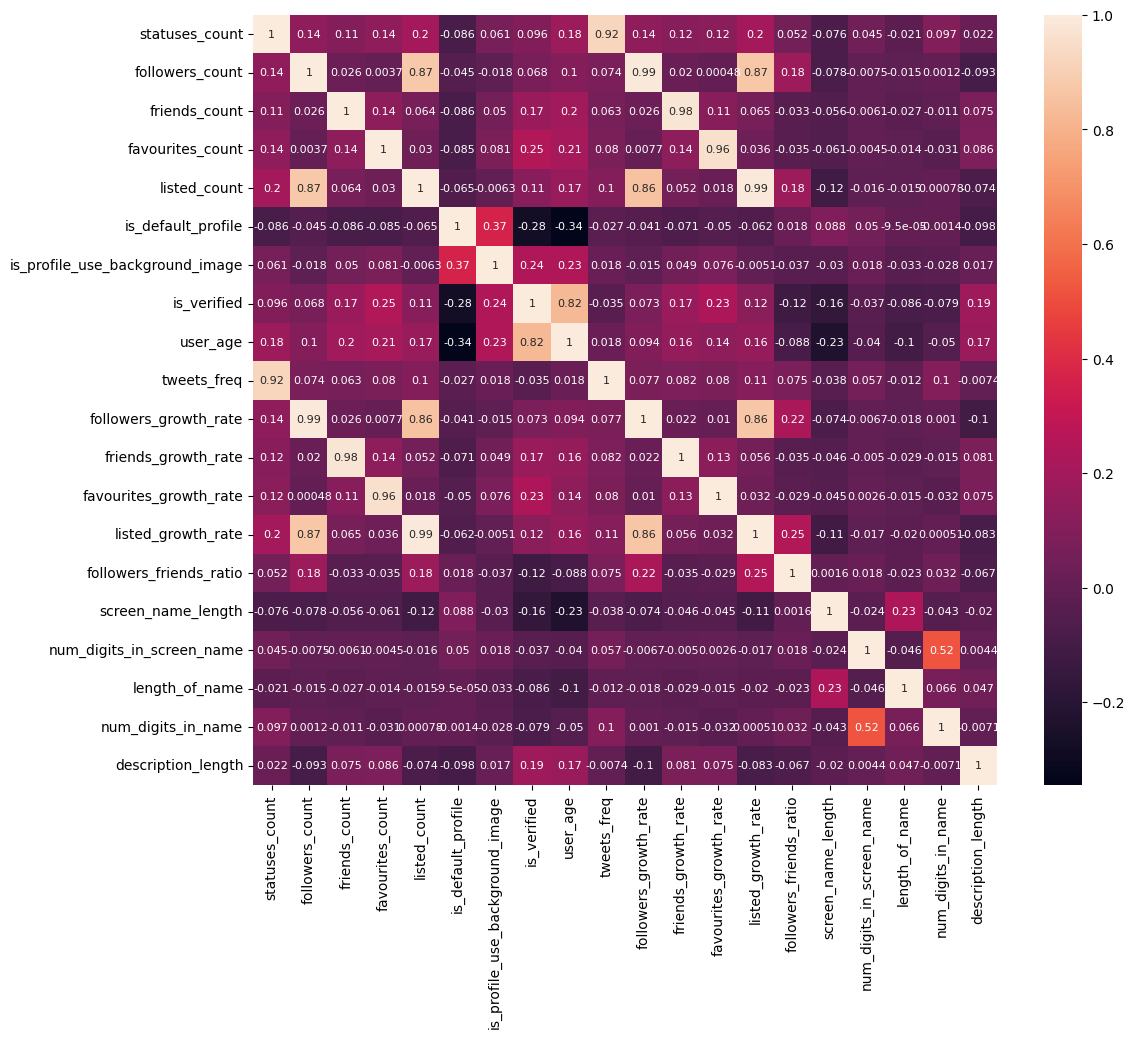

In [11]:
plt.figure(figsize=(12, 10))
sns.heatmap(df_X.corr(), annot=True, annot_kws={"size": 8})

Наиболее удобным способом определить важность признаков является использование поля feature_importances_ классификатора RandomForest. Не для всех, представленных в нашем решении, существует простой способ оценить важность признаков (например, такая ситуация складывается с классификатором KNearestNeighbours). В задании мы не ограничены в выборе метода определения наиболее важных признаков, поэтому мы вправе обучить классификатор RandomForest (что мы уже сделали) и оценить важность признаков с его помощью.

Также мы оценили важность признаков с помощью SelectKBest и метрики chi2.

In [12]:
rf_importances = multiple_gs_stats['RandomForestClassifier'].best_estimator_.feature_importances_

best_features = SelectKBest(score_func=chi2, k=10)
chi2_scores = best_features.fit(df_X, df_y).scores_

feature_importances = pd.DataFrame(index=df_X.columns,
                                   data={
                                       'RF_feature_importances': rf_importances,
                                       'SKB_chi2': chi2_scores
                                    })
feature_importances

,RF_feature_importances,SKB_chi2
statuses_count,0.003642,1.554286
followers_count,0.068553,3.552838
friends_count,0.138424,10.786018
favourites_count,0.164244,17.525460
listed_count,0.040690,4.290273
is_default_profile,0.000960,144.986301
is_profile_use_background_image,0.000631,42.099408
is_verified,0.235615,592.336321
user_age,0.092071,203.395676
tweets_freq,0.003109,0.258225


<AxesSubplot:>

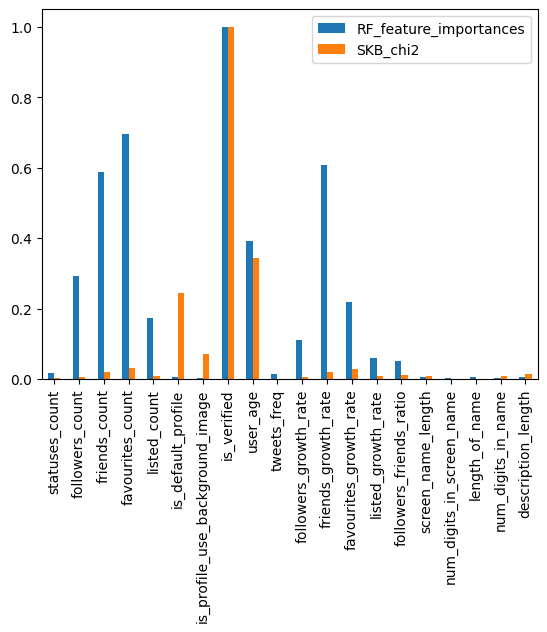

In [13]:
# Нормализуем в [0; 1] для сравнения
(feature_importances / feature_importances.max()).plot(kind='bar')

In [14]:
feature_importances_sorted = feature_importances.sort_values(by=['RF_feature_importances'], ascending=False)
feature_importances_sorted

,RF_feature_importances,SKB_chi2
is_verified,0.235615,592.336321
favourites_count,0.164244,17.525460
friends_growth_rate,0.143097,10.961242
friends_count,0.138424,10.786018
user_age,0.092071,203.395676
followers_count,0.068553,3.552838
favourites_growth_rate,0.051790,16.837523
listed_count,0.040690,4.290273
followers_growth_rate,0.026224,3.507769
listed_growth_rate,0.014153,4.338113


<AxesSubplot:>

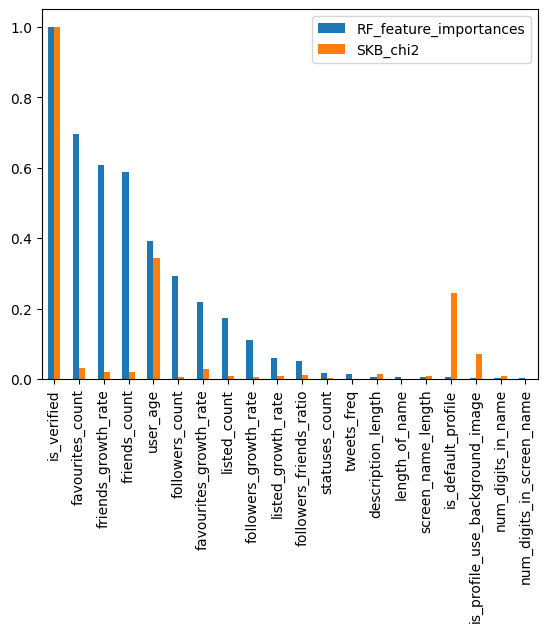

In [15]:
(feature_importances_sorted / feature_importances_sorted.max()).plot(kind='bar')

In [16]:
top_10_features = feature_importances_sorted.iloc[:10].index.tolist()
top_10_features

['is_verified',
 'favourites_count',
 'friends_growth_rate',
 'friends_count',
 'user_age',
 'followers_count',
 'favourites_growth_rate',
 'listed_count',
 'followers_growth_rate',
 'listed_growth_rate']

In [17]:
multiple_gs_stats_10f = {}

for model_name, model_data in experiment_setups.items():
    print(f'Testing {model_name}')

    gs_cv = GridSearchCV(estimator=model_data['model'],
                         param_grid=model_data['param_grid'],
                         scoring='f1',
                         cv=5,
                         verbose=1)

    gs_cv.fit(df_X[top_10_features], df_y)

    multiple_gs_stats_10f.update({model_name: gs_cv})


Testing RandomForestClassifier
Fitting 5 folds for each of 48 candidates, totalling 240 fits
Testing LogisticRegression
Fitting 5 folds for each of 45 candidates, totalling 225 fits
Testing KNeighborsClassifier
Fitting 5 folds for each of 30 candidates, totalling 150 fits
Testing DecisionTreeClassifier
Fitting 5 folds for each of 24 candidates, totalling 120 fits


In [18]:
max_f1_10f = -1
very_best_model_10f = None
very_best_model_name_10f = None
for model_name, gs in multiple_gs_stats_10f.items():
    f1 = gs.best_score_
    print(f'{model_name: ^25}\tf1 = {f1}')
    if f1 > max_f1_10f:
        max_f1_10f = f1
        very_best_model_10f = gs.best_estimator_
        very_best_model_name_10f = model_name

 RandomForestClassifier  	f1 = 0.9916590536203767
   LogisticRegression    	f1 = 0.9875779737058454
  KNeighborsClassifier   	f1 = 0.9868214367475593
 DecisionTreeClassifier  	f1 = 0.9850391780912064


In [19]:
very_best_model_10f

RandomForestClassifier(criterion='entropy', max_depth=4, n_estimators=200)

In [20]:
try:
    very_best_model_10f.predict(df_X.iloc[:1])
except ValueError as e:
    print(e)

X has 20 features, but RandomForestClassifier is expecting 10 features as input.


Видим, что модель в этом эксперименте действительно работает на 10 признаках.

In [21]:
with open(f'{MODELS_DIR}/2.1.pkl', 'wb') as f:
    pickle.dump({'model': very_best_model_10f, 'scaler': scaler}, f)

## 2.2 Обучить модель, обеспечивающую вероятность пропуска бота на уровне не выше 0.03, и имеющую насколько возможно низкую вероятность ложного обнаружения.


In [22]:
# i.e. (recall >= 0.97) && (precision as high as possible)

In [23]:
very_best_model_name

'RandomForestClassifier'

Возьмем тот тип классификатора, который показал лучшие результаты в 1 задании.

In [24]:
X_train, X_test, y_train, y_test = train_test_split(df_X, df_y, test_size=0.2)

In [25]:
model_name = very_best_model_name

print(f'Testing {model_name}')

gs_cv = GridSearchCV(estimator=experiment_setups[model_name]['model'],
                     param_grid=experiment_setups[model_name]['param_grid'],
                     scoring='precision',
                     cv=5,
                     verbose=1)

gs_cv.fit(X_train, y_train)

Testing RandomForestClassifier
Fitting 5 folds for each of 48 candidates, totalling 240 fits


GridSearchCV(cv=5, estimator=RandomForestClassifier(),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [4, 5, 7, 8],
                         'max_features': ['sqrt', 'log2'],
                         'n_estimators': [200, 350, 500]},
             scoring='precision', verbose=1)

In [26]:
print(f'Max precision: {gs_cv.best_score_}')

Max precision: 0.9960000000000001


In [27]:
y_pred_train = gs_cv.best_estimator_.predict(X_train)
y_pred = gs_cv.best_estimator_.predict(X_test)

In [28]:
print(f'Recall of the best model, train data: {recall_score(y_train, y_pred_train)}')
print(f'Recall of the best model, test data: {recall_score(y_test, y_pred)}')

Recall of the best model, train data: 1.0
Recall of the best model, test data: 0.99


In [29]:
with open(f'{MODELS_DIR}/2.2.pkl', 'wb') as f:
    pickle.dump({'model': gs_cv.best_estimator_, 'scaler': scaler}, f)

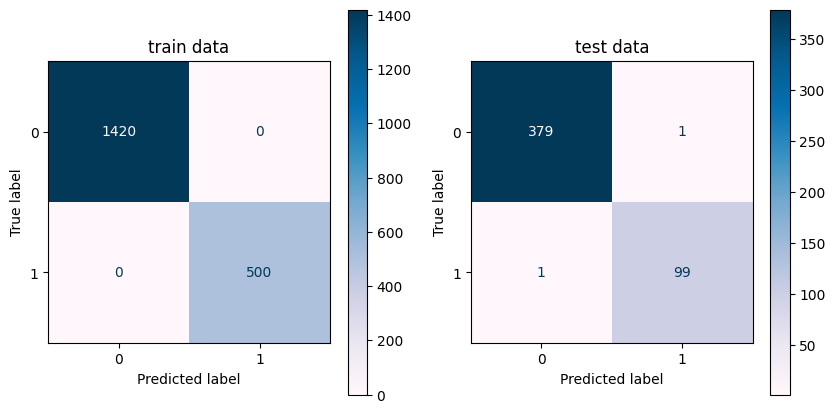

In [30]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
ax1.set_title('train data')
ConfusionMatrixDisplay(confusion_matrix(y_train, y_pred_train)).plot(cmap='PuBu', ax=ax1)
ax2.set_title('test data')
ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred)).plot(cmap='PuBu', ax=ax2)

In [31]:
print(f'precision, train data: {precision_score(y_train, y_pred_train)}')
print(f'precision, test data: {precision_score(y_test, y_pred)}')

print(f'accuracy, train data: {accuracy_score(y_train, y_pred_train)}')
print(f'accuracy, test data: {accuracy_score(y_test, y_pred)}')

precision, train data: 1.0
precision, test data: 0.99
accuracy, train data: 1.0
accuracy, test data: 0.9958333333333333


## Тест функции classify

In [32]:
from classify import classify

In [33]:
train_pred = classify(f'{MODELS_DIR}/1.1.pkl', 'features_train.csv')

In [34]:
train_gt = pd.read_csv('classes_train.csv')['is_bot'].values

In [35]:
np.sum(train_pred == train_gt) / len(train_pred)

1.0

In [36]:
f1_score(train_gt, train_pred)

1.0